In [13]:
pip install 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Found 2152 files belonging to 3 classes.
Epoch 1/2
54/54 [==============================] - 178s 3s/step - loss: 0.9115 - accuracy: 0.4919 - val_loss: 0.8518 - val_accuracy: 0.5833
Epoch 2/2
54/54 [==============================] - 136s 3s/step - loss: 0.7694 - accuracy: 0.6528 - val_loss: 0.6108 - val_accuracy: 0.7188


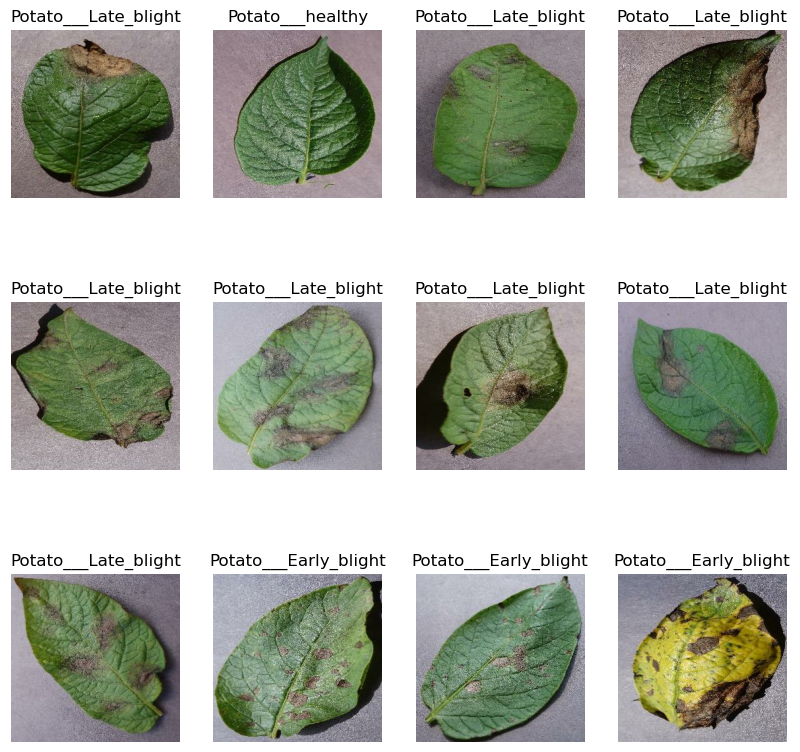

In [1]:

import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=2

dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
class_names
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
train_size=0.8

train_ds=dataset.take(54)
test_ds=dataset.skip(54)
valsize=0.1
val_ds=test_ds.take(6)
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+test_split+val_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size= (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size= (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes ,activation='softmax')  
    
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])
history=model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

In [3]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 321ms/step - loss: 0.1382 - accuracy: 0.9609


first image to predict
actual label Potato___Early_blight
predicted label: Potato___Early_blight


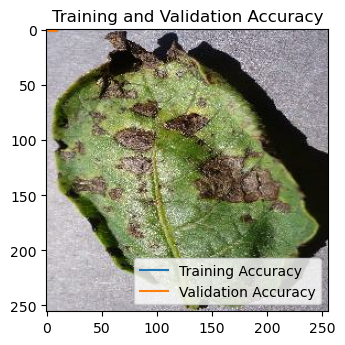

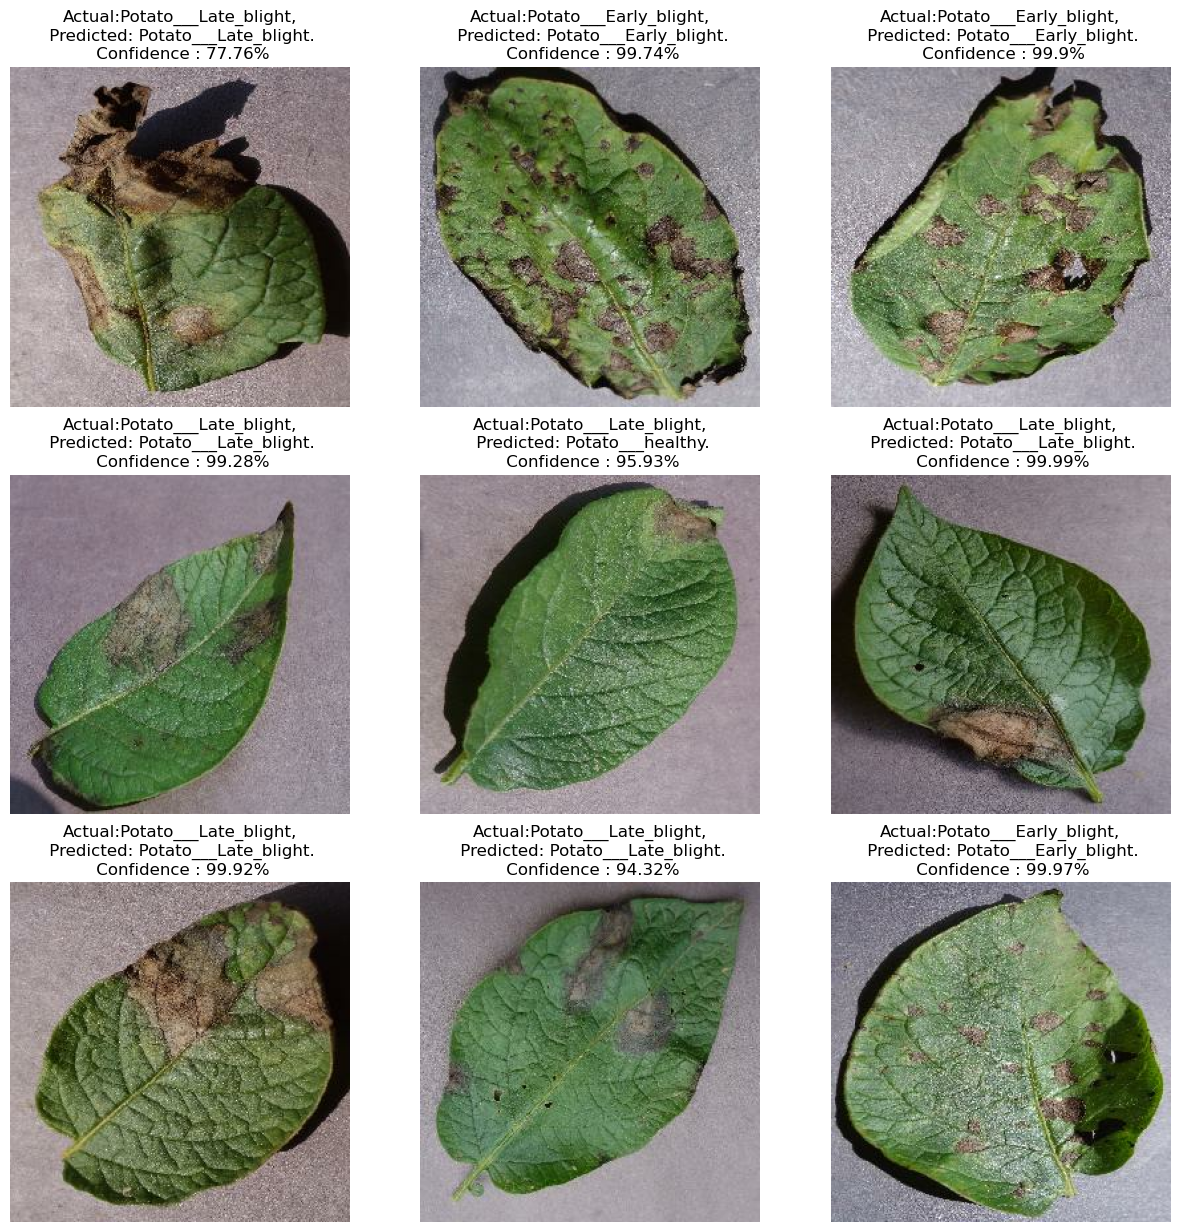

In [2]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
import numpy as np 
for images_batch,labels_batch in test_ds.take(1):
    
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label",class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
                                           
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence : {confidence}%")
                    
        plt.axis("off")

INFO:tensorflow:Assets written to: ../models/1\assets


In [6]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets
